File Download

In [9]:
!wget https://raw.githubusercontent.com/Suppersine/Thesis2021/main/taxiuber/uberday.csv

--2021-05-25 12:55:48--  https://raw.githubusercontent.com/Suppersine/Thesis2021/main/taxiuber/uberday.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1376 (1.3K) [text/plain]
Saving to: ‘uberday.csv.2’

uberday.csv.2       100%[===================>]   1.34K  --.-KB/s    in 0s      

2021-05-25 12:55:48 (75.1 MB/s) - ‘uberday.csv.2’ saved [1376/1376]



Library

In [3]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

convert an array of values into a dataset matrix

In [4]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

Data Plot & preparation

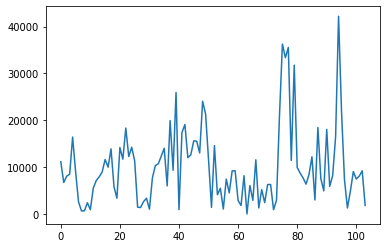

In [5]:
# load the dataset
dataframe = pd.read_csv('uberday.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

dataplot = dataframe.copy()
#training_set = pd.read_csv('shampoo.csv')

#dataplot = dataplot.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(dataplot, label = 'Taxi Daily Ridership Data (104/01-08)')
plt.show()

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
#here, you can change the test size to make future prediction
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


Model & Training

In [6]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
67/67 - 32s - loss: 0.0433
Epoch 2/100
67/67 - 0s - loss: 0.0264
Epoch 3/100
67/67 - 0s - loss: 0.0212
Epoch 4/100
67/67 - 0s - loss: 0.0200
Epoch 5/100
67/67 - 0s - loss: 0.0196
Epoch 6/100
67/67 - 0s - loss: 0.0196
Epoch 7/100
67/67 - 0s - loss: 0.0197
Epoch 8/100
67/67 - 0s - loss: 0.0195
Epoch 9/100
67/67 - 0s - loss: 0.0195
Epoch 10/100
67/67 - 0s - loss: 0.0200
Epoch 11/100
67/67 - 0s - loss: 0.0195
Epoch 12/100
67/67 - 0s - loss: 0.0196
Epoch 13/100
67/67 - 0s - loss: 0.0195
Epoch 14/100
67/67 - 0s - loss: 0.0195
Epoch 15/100
67/67 - 0s - loss: 0.0194
Epoch 16/100
67/67 - 0s - loss: 0.0194
Epoch 17/100
67/67 - 0s - loss: 0.0196
Epoch 18/100
67/67 - 0s - loss: 0.0195
Epoch 19/100
67/67 - 0s - loss: 0.0193
Epoch 20/100
67/67 - 0s - loss: 0.0196
Epoch 21/100
67/67 - 0s - loss: 0.0194
Epoch 22/100
67/67 - 0s - loss: 0.0195
Epoch 23/100
67/67 - 0s - loss: 0.0194
Epoch 24/100
67/67 - 0s - loss: 0.0193
Epoch 25/100
67/67 - 0s - loss: 0.0194
Epoch 26/100
67/67 - 0s - loss: 0

Prediction & RMSE calculation

In [7]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5827.10 RMSE
Test Score: 10332.44 RMSE


Testing Data & Plot

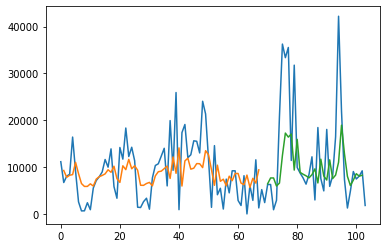

In [8]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()